In [3]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    return result

def frombits(bits):
    chars = []
    for b in range(len(bits) // 8):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

# Demo đọc file âm thanh và xem ...

In [ ]:
Audio(filename='09-saxophone.wav')

In [ ]:
rate, samples = wavfile.read('09-saxophone.wav')

<ipython-input-5-d616dcd5be2a>:1: WavFileWarning: Reached EOF prematurely; finished at 1048576 bytes, expected 2071600 bytes from header.
  rate, samples = wavfile.read('09-saxophone.wav')


In [ ]:
rate

44100

In [ ]:
samples

array([[ -14,   -5],
       [  17,  -40],
       [   3,  -34],
       ...,
       [  87,   72],
       [1178, 1129],
       [2136, 2121]], dtype=int16)

In [ ]:
len(samples)

262133

In [ ]:
# Thời lượng (s)
len(samples) / rate

5.9440589569161

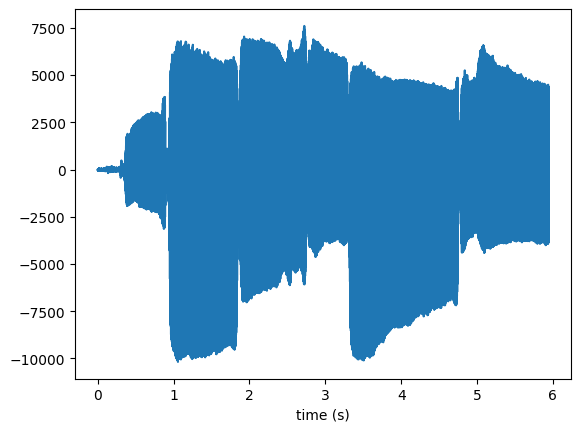

In [ ]:
# Trực quan hóa sóng thứ 1
plt.plot(np.arange(len(samples)) / rate, samples[:, 0])
plt.xlabel('time (s)');

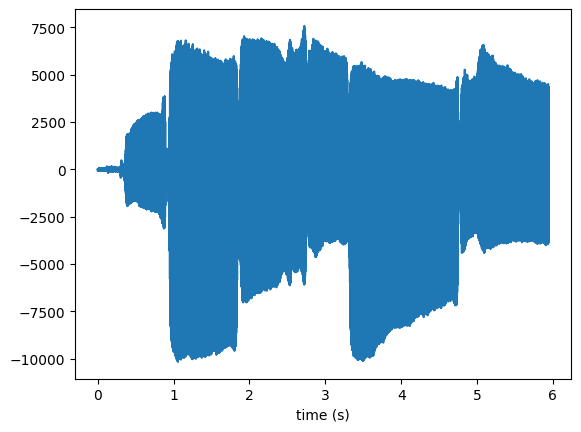

In [ ]:
# Trực quan hóa sóng thứ 2
plt.plot(np.arange(len(samples)) / rate, samples[:, 1])
plt.xlabel('time (s)');

# Demo phương pháp LSB

In [ ]:
def embed(msg_file, cover_audio_file, num_lsbs, stego_audio_file):
    # Đọc cover audio file
    rate, cover_samples = wavfile.read(cover_audio_file)

    # Đọc msg file
    with open(msg_file, 'r') as f:
        msg = f.read()

    # Chuyển msg thành msg bits
    msg_bits = tobits(msg)

    # Kiểm xem có nhúng được không?
    capacity = cover_samples.size * num_lsbs
    if len(msg_bits) + 1 > capacity:
        print('Cannot embed')
        return False

    # Thêm '100...' vào msg bits
    msg_bits.extend('1' + '0' * (capacity - len(msg_bits) - 1))

    # Nhúng msg bits vào cover audio
    stego_samples = np.empty_like(cover_samples)
    for r in range(cover_samples.shape[0]):
        for c in range(cover_samples.shape[1]):
            b = (r * cover_samples.shape[1] + c) * num_lsbs
            stego_samples[r, c] = (cover_samples[r, c]>>num_lsbs<<num_lsbs)\
                                + int(''.join([str(bit) for bit in msg_bits[b:b+num_lsbs]]), 2)

    # Ghi stego audio xuống file
    wavfile.write(stego_audio_file, rate, stego_samples)

    return True

embed('09-msg.txt', '09-saxophone.wav', 1, '09-saxophone_stego.wav')

FileNotFoundError: ignored

In [ ]:
Audio(filename='09-saxophone.wav')

In [ ]:
Audio(filename='09-saxophone_stego.wav')

In [ ]:
def extract(stego_audio_file, num_lsbs, extr_msg_file):
    # Đọc stego audio file
    rate, stego_samples = wavfile.read(stego_audio_file)

    # Rút trích msg bits
    extr_msg_bits = []
    for sample in stego_samples.reshape(-1):
        extr_msg_bits.extend((np.binary_repr(sample & (2**num_lsbs-1), num_lsbs)))

    # Cắt đuôi '100...' ra khỏi msg bits
    extr_msg_bits = extr_msg_bits[:''.join([str(bit) for bit in extr_msg_bits]).rfind('1')]

    # Chuyển msg bits thành msg
    extr_msg = frombits(extr_msg_bits)

    # Ghi msg xuống file
    with open(extr_msg_file, 'w') as f:
        f.write(extr_msg)

extract('09-saxophone_stego.wav', 1, '09-extr_msg.txt')

# Demo tạo sóng có echo và tìm echo bằng autocorrelation

In [ ]:
Audio(filename='09-vocals.wav')

In [ ]:
rate, samples = wavfile.read('09-vocals.wav')

In [ ]:
rate

In [ ]:
samples

Dưới đây chỉ dùng một sóng (cột 0) để demo

In [ ]:
plt.plot(samples[:, 0])

In [ ]:
time_delay = 0.3 # s
sample_delay = int(time_delay * rate)
sample_delay

In [ ]:
echo = np.zeros_like(samples[:, 0])
echo[sample_delay:] = samples[:-sample_delay, 0]

In [ ]:
plt.plot(samples[:, 0])
plt.plot(echo)

In [ ]:
samples_echo = samples[:, 0] + echo

In [ ]:
plt.plot(samples_echo)

In [ ]:
wavfile.write('09-vocals_echo.wav', rate, samples_echo)

In [ ]:
Audio(filename='09-vocals_echo.wav')

**Autocorrelation**

Autocorrelation của một sóng (một mảng) tại độ lệch $k$ cho biết độ tương tự (correlation) của sóng đó với phiên bản dịch trái $k$ phần tử của chính nó. Ở đây, ta chỉ xét $0 \le k \le n-2$ với $n$ là số lượng phần tử của sóng; bỏ qua $k = n-1$ vì với $k = n-1$ thì phiên bản dịch trái chỉ có một phần tử, không có ý nghĩa lắm.

Ví dụ: cho mảng $x = [1, 2, 3, 1, 2, 3]$; tính autocorrelation của $x$ tại độ lệch $k = 1$.

- Phiên bản dịch trái $k=1$ phần tử của $x$: $x' = [2, 3, 1, 2, 3]$
- Autocorrelation được tính như sau: lấy các phần tử của $x$ nhân với các phần tử tương ứng trong $x'$ (chỉ lấy 5 phần tử đầu của $x$ để nhân, bỏ qua phần tử cuối vì không có phần tử tương ứng trong $x'$), rồi lấy trung bình các tích tính được.

In [ ]:
x = np.array([1, 2, 3, 1, 2, 3])
k = 1
np.mean(x[:-k] * x[k:])

Từ cách tính ở trên, có thể thấy: *khi phiên bản dịch trái $k$ phần tử của $x$ tương tự với $x$ thì giá trị autocorrelation sẽ dương và lớn*.  

In [ ]:
x = np.array([1, 2, 3, 1, 2, 3])
for k in range(len(x) - 1):
    if k == 0: # Câu lệnh ở trên không đúng với k = 0 (x[:-0]=rỗng) nên phải xử lý riêng cho trường hợp này
        ac = np.mean(x * x)
    else:
        ac = np.mean(x[:-k] * x[k:])
    print(f'k = {k}, autocorrelation = {ac}')

Ở trên là cách tính autocorrelation đã được đơn giản hóa để giúp bạn nắm được ý tưởng của autocorrelation. Công thức tính autocorrelation đầy đủ sẽ chuẩn hóa kết quả về đoạn $[-1, 1]$ (bằng cách chuẩn hóa $x$ trước khi nhân tương ứng và lấy trung bình; bạn có thể xem công thức tính autocorrelation đầy đủ [ở đây](https://en.wikipedia.org/wiki/Autocorrelation)). Giá trị autocorrelation càng gần 1 nghĩa là càng tương tự nhau.

In [ ]:
x = np.array([1, 2, 3, 1, 2, 3])
temp = (x - x.mean()) / (x.var() ** 0.5) # Chuẩn hóa x trước khi tính
for k in range(len(x) - 1):
    if k == 0:
        ac = np.mean(temp * temp)
    else:
        ac = np.mean(temp[:-k] * temp[k:])
    print(f'k = {k}, autocorrelation = {ac}')

**Dùng autocorrelation để tìm echo**

Quay lại với sóng (mảng) `samples_echo` ở trên. Nhắc lại: sóng này = sóng gốc + echo. Ta muốn xác định độ trễ của echo trong sóng `samples_echo`. Một cách đơn giản là tính autocorrelation của `samples_echo` tại các độ lệch `k` khác nhau. Ta kỳ vọng giá trị autocorrelation của `samples_echo` tại `k` bằng độ trễ của echo sẽ lớn (đúng không?).

In [ ]:
acs = []
temp = (samples_echo - samples_echo.mean()) / (samples_echo.var() ** 0.5)
for k in range(10000): # Tính autocorrelation với 10000 giá trị k đầu tiên
    if k == 0:
        ac = np.mean(temp * temp)
    else:
        ac = np.mean(temp[:-k] * temp[k:])
    acs.append(ac)

In [ ]:
plt.plot(acs)
plt.plot([sample_delay, sample_delay], [-1, 1], '--', alpha=0.5)
plt.xticks([0, sample_delay])
plt.ylim(-1, 1)
plt.xlabel('k'); plt.ylabel('autocorrelation');

Như có thể thấy từ kết quả ở trên, tại $k$ bằng độ trễ của echo, autocorrelation có giá trị lớn; nhưng cũng khó xác định vị trí $k$ này. Tuy nhiên, khi rút trích, ta có thể biết được hai độ lệch của 2 echo ứng với bit 0 và bit 1, và ta có thể rút trích như sau: với mỗi đoạn sóng được nhúng bit, ta sẽ tính giá trị autocorrelation tại hai độ trễ ứng với bit 0 và bit 1, nếu giá trị nào lớn hơn thì ta sẽ quyết định có echo tại độ trễ đó và rút trích ra bit tương ứng.